# Linear Regression

From scratch implementation of Linear Regression Model. 

The linear Regression is optimzed by using the cost objective of OLS. One implementation contains the implementaion of the `normal equation`:

$$X\beta = y \longrightarrow X^TX\beta=X^Ty \longrightarrow (X^TX)^{-1}X^TX\beta = (X^TX)^{-1}X^Ty \longrightarrow I\beta = (X^TX)^{-1}X^Ty$$

and the other implementation works with the Gradient Descent algorithm which optimizes the `Ordinary Least Square` Cost-Function:

#### OLS-Costfunction
$$J(\beta{0..n}) = \frac{1}{2N}\sum_{i=1}^{N} (y_i - \hat{y}_i)^2 = \frac{1}{2N}\sum_{i=1}^{N} (y_i - \beta_0 + X_1 \beta_1 ... X_n\beta_n)^2 =\frac{1}{2N}\sum_{i=1}^{N} (y_i - X\beta)^2$$

This can also be rewritten in matrix-notation:
$$ \frac{1}{2N}\sum_{i=1}^{N} (y_i - X\beta)^T(y_i - X\beta)$$

#### Derivation of the Cost-Function

The derivation w.r.t. $\beta_0$ looks as followed:

$$\frac{\partial J(\beta_{0..n})}{\partial \beta_0}=\frac{1}{N} \sum_{i=1}^{N}(y_i - \beta_0 + X_1 \beta_1 ... X_n\beta_n) \longrightarrow
 \frac{1}{N} \sum_{i=1}^{N}(y_i - X\beta) $$

The derivation w.r.t $\beta_{1..n}$ looks like this:

$$\frac{\partial J(\beta_{0..n})}{\partial \beta_{1..n}} = \frac{1}{N} \sum_{i=1}^{N} x_i*(y_i - \beta_0 + x_1 \beta_1 ... x_n\beta_n) $$

If we rewrite this expression this is exactly the same as:

$$ \frac{\partial J(\beta_{0..n})}{\partial \beta_{1..n}} = \frac{1}{N} X^T(y_i - X\beta) = \frac{1}{N} X^Ty-X^TX\beta$$

Here the sum is not needed anymore as it is already implied by the matrix product. Our rewritten partial derivative w.r.t to $\beta_{1..n}$ does look pretty similar to what we have in our normal equation. If we now consider this term to zero then

$$\frac{1}{N} X^Ty-X^TX\beta = 0 \longrightarrow X^Ty=X^TX\beta \longrightarrow (X^TX)^{-1}X^Ty=\beta$$

we end up with the normal equation, which corresponds exactly with the OLS-costfunction derivative.

 If we put a vector, which consists of ones, to our Matrix $X$ then we do not need a separate derivative for $\beta_0$ as its derivative is included in the derivative for all other betas.  

For more information check-out the article about Linear Regression in [(Murphy, 2012, p.221/222)](https://www.amazon.de/Machine-Learning-Probabilistic-Perspective-computation/dp/0262018020/ref=sr_1_1?__mk_de_DE=%C3%85M%C3%85%C5%BD%C3%95%C3%91&dchild=1&keywords=murphy+a+probabilistic&qid=1624541492&sr=8-1)

In [180]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from matplotlib import pyplot as plt

In [202]:
X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [203]:
class LinearRegression(BaseEstimator):
    """This class implements a Simple Linear Regression Model"""
    
    def __init__(self, opt_method='nq', 
                 learning_rate=.1, epsilon=.001, max_iter=1000,
                 standardize=True):
        """
        This function initializes the class LineareRegression which implements two different ways of 
        Linear Regressions. Once with Normalequation and once with OLS-Gradient Descent.
        
        params:
        ---------------
        opt_method:     
                    This parameter is to chose between normal equation ("nq") and gradient descent
                    of OLS-costfunciton ("OLS")
                    
        learning_rate:
                    Parameter only relevant with opt_method = "OLS"
                    Learning rate for the parameter update of gradient descent. 
                    
        epsilon:
                    Parameter only relevant with opt_method = "OLS"
                    This parameter is for the early stop of the Gradient Descent. It stops when the length
                    of gradient converges. the lenght is calculated with the eucliden norm of the gradient.
                    
        max_iter:
                    Parameter only relevant with opt_method = "OLS"!
                    Maximum of iterations which should be performed with gradient descent
                    
        standardize:
                    If this paramter is set to True, then X will be stanardize before fitting
                    The standardization corresponds with the Z-score of the standardnormal distribution
                    Subtraction of Mean (Mean centering) and standard deviation of 1. 
                    formula: Z = X - mean(X) / std(X)
                    
        beta_:
                    Modell Coefficients
                    
        cost_:
                    Parameter only relevant with opt_method = "OLS"
                    Calculated Costs of each iteration of GD.
                    
        learning_history:
                    Parameter only relevant with opt_method = "OLS"
                    The learning are the lengths of the gradients within each iteration of GD.
         
        """
        self.opt_method = opt_method
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.standardize = standardize
        
        self.beta_ = None
        self.cost_ = []
        self.learning_history = []
        
        
    def fit(self, X, y):
        """
        Fits the model to given training data X, y.
        
        arguments:
        ---------------
        X:      Train Data X
        y:      Target Data y
        
        returns:
        ---------------
        None        
        """
        # Standardize X if standardize set to True
        if self.standardize:
            for c in range(X.shape[1]):
                X[:,c] = (X[:,c] - np.mean(X[:,c])) / np.std(X[:,c], ddof=1)
        
        # Add Column of ones to Matrix X   
        X = np.hstack((X, np.ones(X.shape[0]).reshape(-1,1)))

        if self.opt_method == 'nq':
            self.beta_ = LinearRegression.normal_equation(X_=X, y_=y)
            
        if self.opt_method == 'OLS':
            # Init params
            self.beta_ = np.random.normal(size=X.shape[1])
            
            iteration, length_of_gradient = 0, 1
            while iteration < self.max_iter and self.epsilon < length_of_gradient:
                
                # Call gradient descent function
                beta_update = self._gradient(X_=X, y_=y, beta_=self.beta_)
                
                # calculate length of gradient
                length_of_gradient = np.linalg.norm(self.learning_rate * beta_update)
                self.learning_history.append(length_of_gradient)
                
                # Update the betas with learning rate
                self.beta_ = self.beta_ - self.learning_rate * beta_update
                
                if length_of_gradient < self.epsilon:
                    print(f'---- Gradient converged at {iteration+1} of {self.max_iter} Iterations ----')
                
                # Calculate iteration cost
                self._cost_function(X_=X, y_=y)
                iteration += 1            
            
        return self
        
        
    def predict(self, X):
        """
        Predicts y with trained model parameters beta.
        
        arguments:
        ---------------
        X:      Train Data X
        
        returns:
        ---------------
        y:
            Model Predictions
            
        """
        X = np.hstack((X, np.ones(X.shape[0]).reshape(-1,1)))
        
        return X @ self.beta_
        
    def score(self, X, y):
        """
        Calculates MSE on given X and y
        
        arguments:
        ------------
        X:        Train Data X
        y:        Target data y
        
        returns:
        -----------
        score:    Mean-Squared Error Score on predictions and y_true
        """
        y_pred = self.predict(X)
        
        return np.mean((y-y_pred)**2)
    
    def _cost_function(self, X_, y_):
        """
        Calculates OLS-Cost function of each iteration of GD.
        
        ols = (1/(2*X_.shape[0])) * sum((y_ - y_pred)**2)
        
        arguments:
        -------------
        X:        Train Data X
        y:        Target data y
        
        """
        y_pred = self.predict(X=X_[:,:-1])
        ols = (1/(2*X_.shape[0])) * np.sum((y_ - y_pred)**2)
        self.cost_.append(ols)
        
    @staticmethod
    def normal_equation(X_, y_):
        """Implementation of the Normalequation
        
        Formula: (X^TX)^-1 @ X^T @ y = b
        
        arguments:
        ------------
        X_:        Train Data X
        y_:        Target data y
        
        returns:
        -----------
        beta:      Computed Betas    
        """
        return np.linalg.inv(X_.T @ X_) @ X_.T @ y_
               
    @staticmethod
    def _gradient(X_, y_, beta_):
        """Calculates Gradients and returns beta updates for one iteration.
        
        arguments:
        ------------
        X_:        Train Data X
        y_:        Target data y
        
        returns:
        -----------
        gradient:  Calculated Gradient with derived OLS-Costfunction   
        """
        return (1/X_.shape[0]) * (-1*X_.T @ (y_ - X_@beta_))
        

In [221]:
model = LinearRegression(opt_method='OLS', learning_rate=.1, standardize=False)
model.fit(X,y)

---- Gradient converged at 521 of 1000 Iterations ----


LinearRegression(opt_method='OLS', standardize=False)

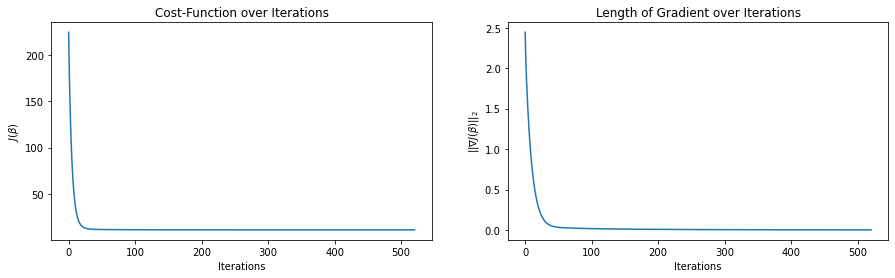

In [223]:
fig = plt.subplots(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(model.cost_)
plt.title('Cost-Function over Iterations')
plt.ylabel(r'$J(\beta)$')
plt.xlabel('Iterations')

plt.subplot(1,2,2)
plt.plot(model.learning_history)
plt.title('Length of Gradient over Iterations')
plt.ylabel(r'$|| \nabla J(\beta) ||_2$')
plt.xlabel('Iterations')

plt.show()